## Parsing and Structuring Time-Series from NASDAQ

Here the goal is to combine and tidy the individual time-series obtained from NASDAQ along with relevant metadata for further analysis.

In [2]:
import pandas as pd
import numpy as np
import json
import os 
from tqdm import tqdm

with open("config.json","r") as f:
    config = json.load(f)
    
# Read list of files    
list_of_data = os.listdir(config["data_dir"])
list_of_df = [pd.read_csv(config["data_dir"] + "/" + x)\
                                        for x in list_of_data]

for i in tqdm(range(len(list_of_data))): 
    list_of_df[i]["Symbol"] = list_of_data[i][:-4] # Add ticker symbols
    list_of_df[i]['Date'] = pd.to_datetime(list_of_df[i]['Date'], # Format date column
                                          infer_datetime_format=True)
    try:
        list_of_df[i]['Close/Last'] = pd.to_numeric(list_of_df[i]['Close/Last'].str.replace("\\$",""))
        list_of_df[i]['Open'] = pd.to_numeric(list_of_df[i]['Open'].str.replace("\\$",""))
        list_of_df[i]['High'] = pd.to_numeric(list_of_df[i]['High'].str.replace("\\$",""))
        list_of_df[i]['Low'] = pd.to_numeric(list_of_df[i]['Low'].str.replace("\\$",""))
    except:
        pass
    
ts_data = pd.concat(list_of_df)# Rbind
# Add meta data
ts_data = pd.merge(ts_data,
                   pd.read_csv(config['metadata'])[['Symbol',
                                                    'Name',
                                                    'Market Cap',
                                                    'Country',
                                                    'IPO Year',
                                                    'Sector',
                                                    'Industry'
                                                   ]]
                   ,on = "Symbol")

100%|█████████████████████████████████████████████████████████████████████████████| 3833/3833 [00:25<00:00, 144.16it/s]


In [3]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2870346 entries, 0 to 2870345
Data columns (total 13 columns):
Date          datetime64[ns]
Close/Last    float64
Volume        float64
Open          float64
High          float64
Low           float64
Symbol        object
Name          object
Market Cap    float64
Country       object
IPO Year      float64
Sector        object
Industry      object
dtypes: datetime64[ns](1), float64(7), object(5)
memory usage: 306.6+ MB


In [4]:
# Unique sectors in the data
print (ts_data['Sector'].unique())
# Unique industries
print(ts_data['Industry'].unique())

[nan 'Health Care' 'Transportation' 'Finance' 'Technology' 'Capital Goods'
 'Consumer Durables' 'Miscellaneous' 'Basic Industries'
 'Consumer Services' 'Public Utilities' 'Energy' 'Consumer Non-Durables']
[nan 'Biotechnology: Pharmaceutical Preparations'
 'Air Freight/Delivery Services' 'Life Insurance' 'Semiconductors'
 'Industrial Machinery/Components' 'Computer Manufacturing'
 'Transportation Services' 'Major Banks' 'Business Services'
 'Biotechnology: In Vitro & In Vivo Diagnostic Substances'
 'Medical/Dental Instruments'
 'Biotechnology: Biological Products (No Diagnostic Substances)'
 'Hospital/Nursing Management' 'EDP Services' 'Specialty Chemicals'
 'Specialty Insurers' 'Multi-Sector Companies'
 'Computer Software: Prepackaged Software' 'Industrial Specialties'
 'Telecommunications Equipment' 'Medical/Nursing Services' 'Advertising'
 'Electrical Products' 'Building operators'
 'Diversified Commercial Services' 'Electric Utilities: Central'
 'Environmental Services' 'Television 

In [20]:
# Date range
print(ts_data['Date'].max(),"-",ts_data['Date'].min())

2021-12-10 00:00:00 - 2016-12-05 00:00:00


In [5]:
from tqdm import tqdm
# add % valuation change for a given ticker
tickers = ts_data['Symbol'].unique()
def calculate_perc_change(ticker):
    x = ts_data[ts_data['Symbol'] == ticker]
    price_diff = -1 * np.diff(x['Close/Last'])
    price_diff_perc = 100 * (price_diff / x['Close/Last'][1:])
    price_diff_perc = np.append(price_diff_perc,0)
    x['price_diff_perc'] = price_diff_perc
    return x
ts_data_expand = [calculate_perc_change(ticker) for ticker in tqdm(tickers)]
ts_data_expand = pd.concat(ts_data_expand)    

  0%|                                                                                         | 0/3822 [00:00<?, ?it/s]C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
100%|██████████████████████████████████████████████████████████████████████████████| 3822/3822 [15:30<00:00,  4.16it/s]


In [6]:
ts_data_expand.head()

,Date,Close/Last,Volume,Open,High,Low,Symbol,Name,Market Cap,Country,IPO Year,Sector,Industry,price_diff_perc
0,2021-12-03,9.780,6389.0,9.770,9.780,9.750,AACI,Armada Acquisition Corp. I Common Stock,202538910.0,United States,2021.0,NaN,NaN,0.051151
1,2021-12-02,9.775,43524.0,9.780,9.790,9.760,AACI,Armada Acquisition Corp. I Common Stock,202538910.0,United States,2021.0,NaN,NaN,-0.051125
2,2021-12-01,9.780,101595.0,9.880,9.880,9.780,AACI,Armada Acquisition Corp. I Common Stock,202538910.0,United States,2021.0,NaN,NaN,-0.051099
3,2021-11-30,9.785,NaN,9.785,9.785,9.785,AACI,Armada Acquisition Corp. I Common Stock,202538910.0,United States,2021.0,NaN,NaN,-0.000000
4,2021-11-29,9.785,1436.0,9.890,9.890,9.780,AACI,Armada Acquisition Corp. I Common Stock,202538910.0,United States,2021.0,NaN,NaN,4.764454


In [13]:
ts_data_expand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2870346 entries, 0 to 2870345
Data columns (total 14 columns):
Date               datetime64[ns]
Close/Last         float64
Volume             float64
Open               float64
High               float64
Low                float64
Symbol             object
Name               object
Market Cap         float64
Country            object
IPO Year           float64
Sector             object
Industry           object
price_diff_perc    float64
dtypes: datetime64[ns](1), float64(8), object(5)
memory usage: 328.5+ MB


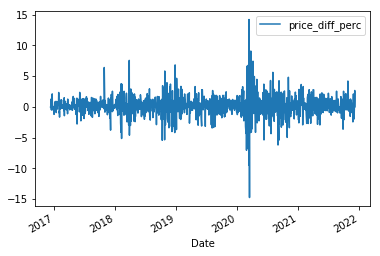

In [11]:
ts_data_expand[ts_data_expand['Symbol'] == "MSFT"].plot(x = "Date", y = "price_diff_perc")

In [12]:
# Serialize and save the data
import pickle as pkl
with open("./data/ts_data.pkl","wb") as f:
    pkl.dump(ts_data_expand,f)

In [10]:
import pickle as pkl
import numpy as np
import pandas as pd

with open("./data/ts_data.pkl", 'rb') as f:
    ts_data = pkl.load(f)

## Exploration and building expectations from data

### Which stocks had highest % yield since 2017?

In [11]:
ts_data_summary = ts_data.groupby("Symbol",as_index= False)\
    ['price_diff_perc'].sum().\
    sort_values('price_diff_perc',ascending = False)
    
ts_data_summary.head(10)    

,Symbol,price_diff_perc
2789,PNTG,1.509000e+07
2728,PFHD,1.349996e+07
3427,TOI,9.699890e+06
3609,VINC,9.349938e+06
3428,TOIIW,2.479944e+06
2241,MDIA,1.920580e+06
2700,PCTTW,1.050259e+06
557,BRY,9.499427e+05
1420,FVE,6.535715e+05
242,APPHW,5.490594e+05


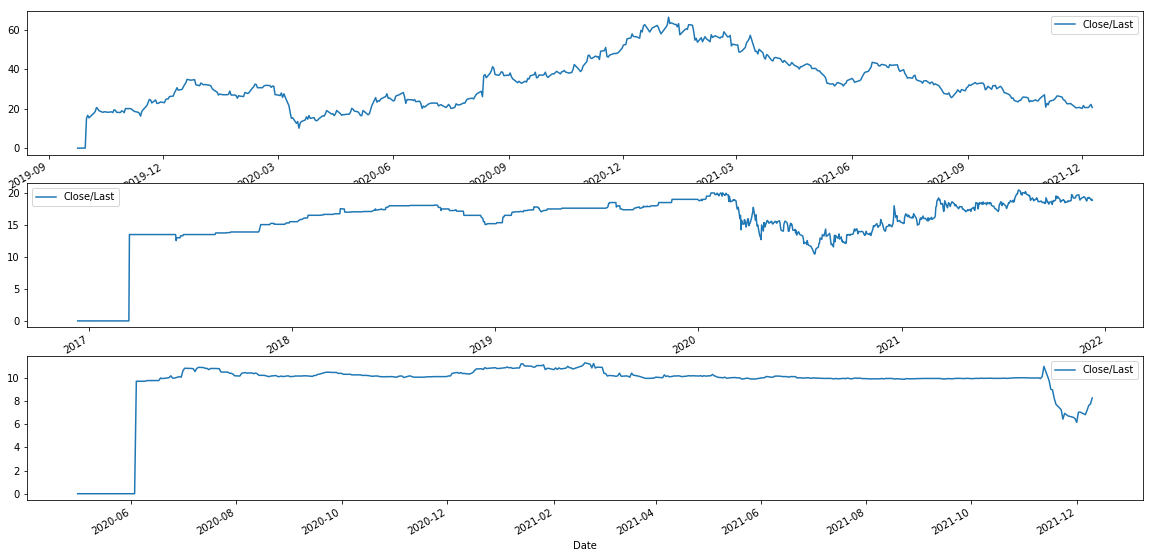

In [12]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
fig, axes = plt.subplots(nrows=3)
ts_data[ts_data.Symbol == "PNTG"].plot.line(x = "Date", y = "Close/Last",ax= axes[0])
ts_data[ts_data.Symbol == "PFHD"].plot.line(x = "Date", y = "Close/Last",ax= axes[1])
ts_data[ts_data.Symbol == "TOI"].plot.line(x = "Date", y = "Close/Last",ax= axes[2])

In [13]:
ts_data[ts_data.Symbol == "PFHD"][['Date','Close/Last','Volume']].tail()

,Date,Close/Last,Volume
2037047,2016-12-16,0.0001,NaN
2037048,2016-12-15,0.0001,NaN
2037049,2016-12-14,0.0001,NaN
2037050,2016-12-13,0.0001,NaN
2037051,2016-12-12,0.0001,NaN


In [14]:
ts_data[ts_data.Symbol == "TOI"][['Date','Close/Last','Volume']].tail()

,Date,Close/Last,Volume
2546535,2020-05-07,0.0001,NaN
2546536,2020-05-06,0.0001,NaN
2546537,2020-05-05,0.0001,NaN
2546538,2020-05-04,0.0001,NaN
2546539,2020-05-01,0.0001,NaN


It looks like the initial market prices for recent stocks are recorded as 0.0001, which is creating an anomaly in the data. Let's clean up these records and update data to get a more realistic picture on valuation.

In general, the valuations below $1 are not sustainable for a given stock and it may indicate financial trouble.(https://www.findlaw.com/smallbusiness/business-finances/markets-and-listing-requirements.html#:~:text=NASDAQ%20National%20Market%20(NASDAQ)&text=Initial%20Minimum%20Bid%20Price%20for,remain%20at%20or%20above%20%241.00.)  

Hence, I will clean up the data to remove the data points that are below $1 for the Closing price. This will introduce missing data for some of the resulting the time-series.

In [15]:
ts_data = ts_data[ts_data['Close/Last'] >= 1]

from tqdm import tqdm
# add % valuation change for a given ticker
tickers = ts_data['Symbol'].unique()
def calculate_perc_change(ticker):
    x = ts_data[ts_data['Symbol'] == ticker]
    price_diff = -1 * np.diff(x['Close/Last'])
    price_diff_perc = 100 * (price_diff / x['Close/Last'][1:])
    price_diff_perc = np.append(price_diff_perc,0)
    x['price_diff_perc'] = price_diff_perc
    return x
ts_data_expand = [calculate_perc_change(ticker) for ticker in tqdm(tickers)]
ts_data_expand = pd.concat(ts_data_expand) 

  0%|                                                                                         | 0/3708 [00:00<?, ?it/s]C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
100%|██████████████████████████████████████████████████████████████████████████████| 3708/3708 [10:54<00:00,  5.71it/s]


In [24]:
import pickle as pkl
with open("./data/ts_data.pkl","wb") as f:
    pkl.dump(ts_data_expand,f)

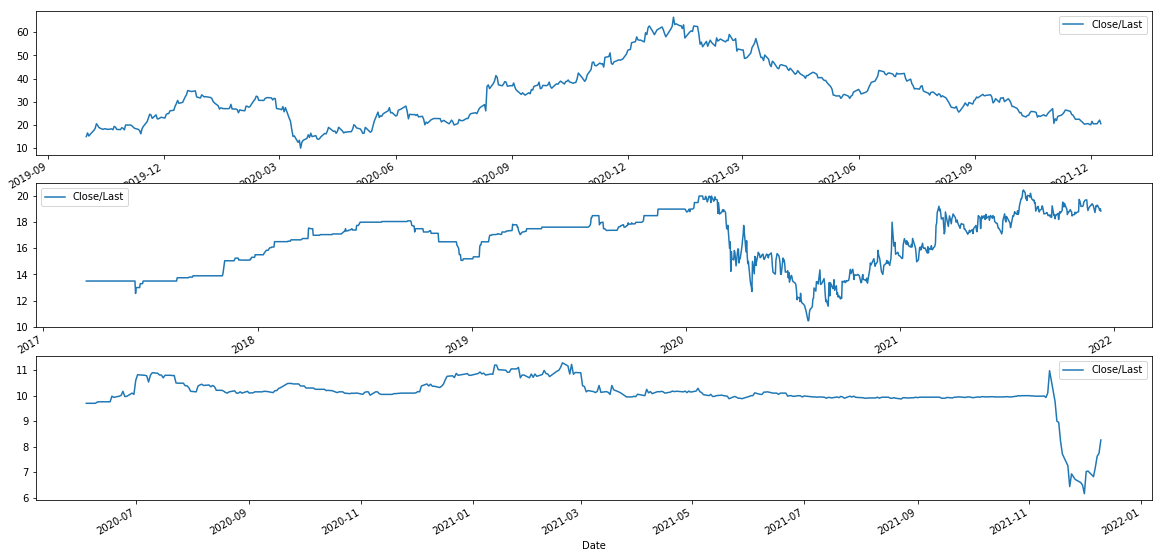

In [16]:
ts_data = ts_data_expand
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
fig, axes = plt.subplots(nrows=3)
ts_data[ts_data.Symbol == "PNTG"].plot.line(x = "Date", y = "Close/Last",ax= axes[0])
ts_data[ts_data.Symbol == "PFHD"].plot.line(x = "Date", y = "Close/Last",ax= axes[1])
ts_data[ts_data.Symbol == "TOI"].plot.line(x = "Date", y = "Close/Last",ax= axes[2])

In [17]:
ts_data_summary = ts_data.groupby("Symbol",as_index= False)\
    ['price_diff_perc'].sum().\
    sort_values('price_diff_perc',ascending = False)
    
ts_data_summary.head(10)    

,Symbol,price_diff_perc
2446,OAS,2668.401717
1299,FORA,2220.382058
2421,NVOS,1136.795334
1029,DTST,1097.064170
2178,MEDS,1050.611821
1461,GLSI,1016.102567
2984,SAVA,946.445576
1829,ISUN,929.892100
3418,UGRO,898.082427
2237,MOBQ,831.573732


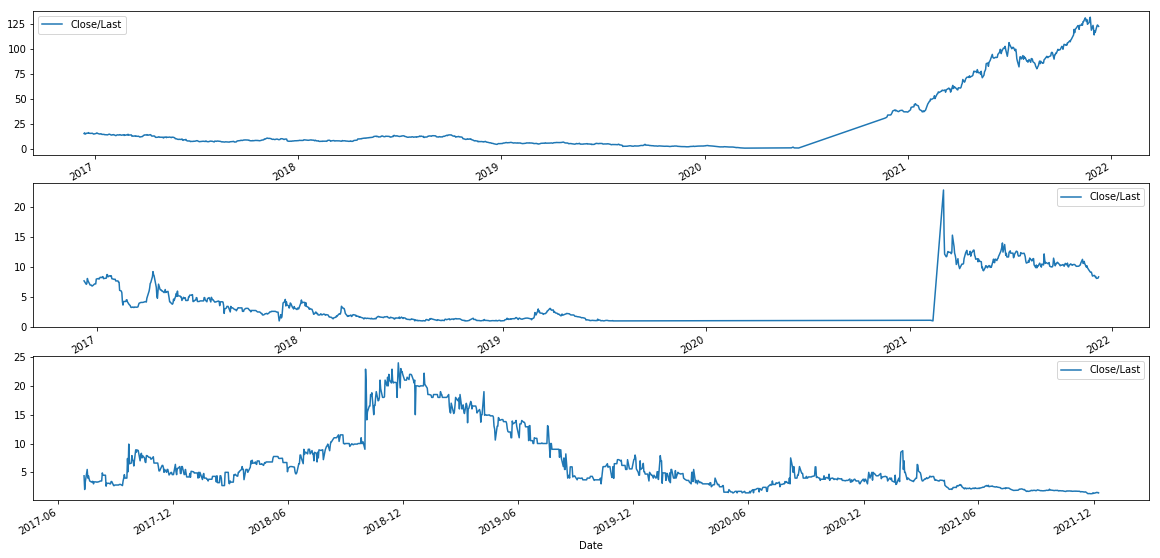

In [18]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
fig, axes = plt.subplots(nrows=3)
ts_data[ts_data.Symbol == "OAS"].plot.line(x = "Date", y = "Close/Last",ax= axes[0])
ts_data[ts_data.Symbol == "FORA"].plot.line(x = "Date", y = "Close/Last",ax= axes[1])
ts_data[ts_data.Symbol == "NVOS"].plot.line(x = "Date", y = "Close/Last",ax= axes[2])

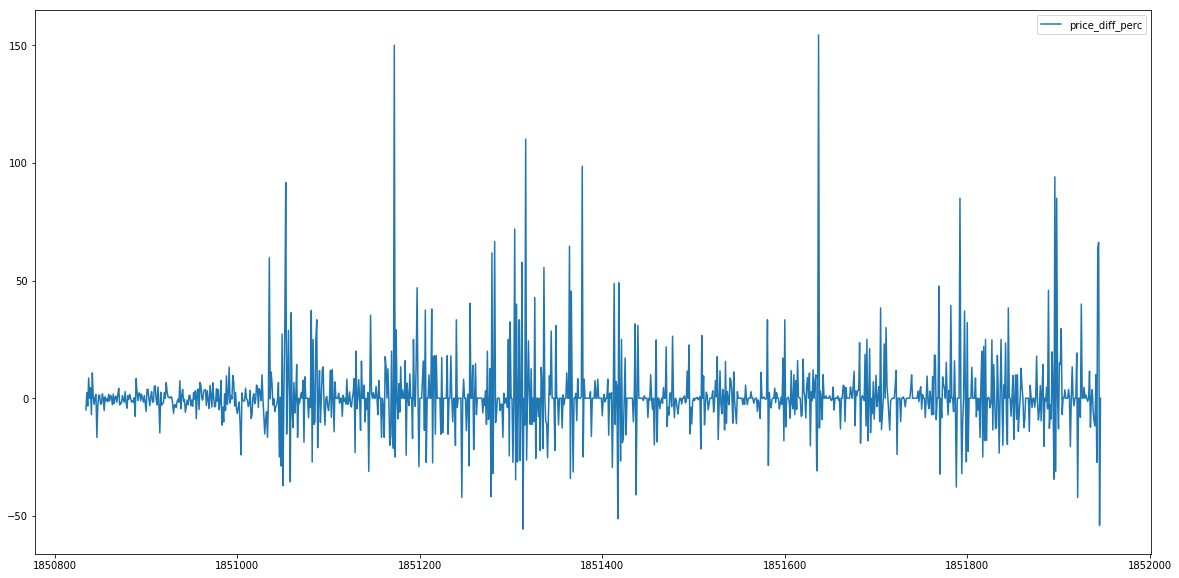

In [23]:
ts_data[ts_data.Symbol == "NVOS"][['price_diff_perc']].plot()

In [1]:
%qtconsole